# Standard deviation of a count variable 

Here's a [question from the Reddit statistics forum](https://www.reddit.com/r/statistics/comments/1c1s7qo/q_is_taking_the_sd_of_a_count_variable_helpful/).

> Is taking the standard deviation of a count variable helpful?
>
> A student brought this up to me in class this week and I had no idea how to answer. For some context they are doing in experiment that involves a count variable and then have a choice of what inferential stat test they want to run. If they pick a t-test they need to show SD error bars on their graph but one student kept telling me it isn't possible. I've spent time looking around forums and asked my PI who also shrugged since we're chemistry people. I was just wondering if someone can explain if finding the SD of a count variable is possible, and if it is, does it tell you anything important or is it just a waste of time? 

In a follow-up, OP provided more context:

> To be specific students were counting the amount of eggs laid on two different types of substrate in petri dishes (something like wood and grass). They were then given the option to choose whatever inferential stat test they thought best fits the data and a number of them chose unpaired t-tests. They used [statistical software] to do the actual test (plugging in the count numbers from 2 variables with 3 replicates, so 6 numbers in total) .
>
> It was my understanding that because the data probably doesn't follow a normal distribution, SD error bars wouldn't really be helpful.

There are several questions going on here, so let's start with the headline -- is taking the SD of a count variable helpful? 

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/DataQnA/blob/main/nb/count_data.ipynb)

I'll download a utilities module with some of my frequently-used functions, and then import the usual libraries.

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

download('https://github.com/AllenDowney/DataQnA/raw/main/nb/utils.py')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils import decorate

In [2]:
# install the empiricaldist library, if necessary

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

## Generating a dataset

Count data are often well modeled by a negative binomial distribution, so that's what I'll use to generate a dataset.

In [3]:
from scipy.stats import nbinom

n = 4
p = 0.5

np.random.seed(17)
data = nbinom.rvs(n, p, size=100)

Here's what the distribution of values looks like.
I'm using a `Pmf` object, which shows all of the values, rather than a histogram, which puts the values into bins. 

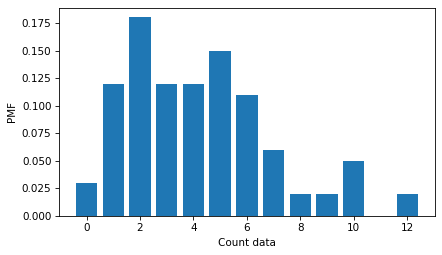

In [4]:
from empiricaldist import Pmf

pmf = Pmf.from_seq(data)
pmf.bar()

decorate(xlabel='Count data', ylabel='PMF')

We can compute the mean and standard deviation of the data in the usual way.

In [5]:
m = np.mean(data)
m

4.23

In [6]:
s = np.std(data)
s

2.7160817366198686

Now the question is whether reporting the standard deviation of this dataset is useful as a descriptive statistic.
I think it's OK -- it quantifies the spread of the distribution, just as it's intended to.

The only problem is that when you report a mean and standard deviation, people often picture a normal distribution, and in this example, that picture is misleading.
To see why, I'll plot the distribution of the data again, along with a normal distribution with the same mean and standard deviation.

In [7]:
from scipy.stats import norm

qs = np.linspace(m - 4*s, m+4*s)
ps = norm(m, s).pdf(qs)

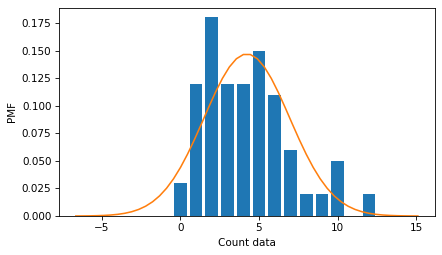

In [8]:
pmf.bar()
plt.plot(qs, ps, color='C1')

decorate(xlabel='Count data', ylabel='PMF')

The normal distribution is symmetric, unlike the distribution of the data, which is skewed to the right.
And the normal distribution extends to negative values, which count data cannot.

So, rather than reporting mean and standard deviation, it might be better to report a median and interquartile range (IQR).

In [9]:
low, median, high = np.percentile(data, [25, 50, 75])
low, median, high

(2.0, 4.0, 6.0)

In [10]:
iqr = high - low
median, iqr

(4.0, 4.0)

A less common alternative would be to fit a negative binomial distribution to the data and report the estimated parameters.
We can do that in this example by matching moments.

In [11]:
p_estimate = m / (s ** 2)
n_estimate = m * p_estimate / (1 - p_estimate)
n_estimate, p_estimate

(5.685520002542022, 0.5733960499383226)

With these parameters, we can compute the PMF of a negative binomial distribution, and see that it fits the data reasonably well.

In [12]:
qs = np.arange(np.max(data) + 3)
ps = nbinom(n_estimate, p_estimate).pmf(qs)

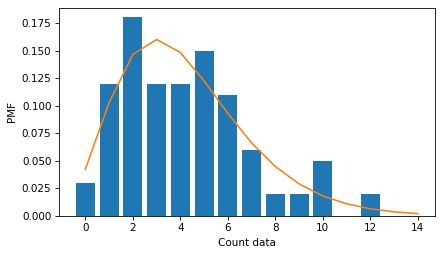

In [13]:
pmf.bar()
plt.plot(qs, ps, color='C1')

decorate(xlabel='Count data', ylabel='PMF')

So that's my answer to the first question -- there's nothing wrong with reporting the standard deviation of a count variable, as long as we don't assume that the distribution is normal.

## What about those error bars?

OP also asked about showing "SD error bars".
I'm not sure what they mean, but I think they are confusing standard deviation and standard error.

* Standard deviation is a descriptive statistic that quantifies the spread of a dataset.

* Standard error is an inferential statistic that quantifies the precision of an estimate.

For example, suppose we use this sample to estimate the mean in the population.
We might wonder how precise the estimate is.
One way to answer that question is to ask how much the result varies if we run the experiment many times.
We can answer that question by bootstrap resampling.

The following function takes a dataset as a parameter, draws a random sample from it with replacement, and returns the mean of the resampled data.

In [14]:
def bootstrap_mean(data):
    resampled = np.random.choice(data, size=len(data), replace=True)
    return np.mean(resampled)

If we call this function 1000 times, we get a sample from from sampling distribution of the mean.

In [15]:
sample = [bootstrap_mean(data) for i in range(1000)]

Here's what the sampling distribution looks like.

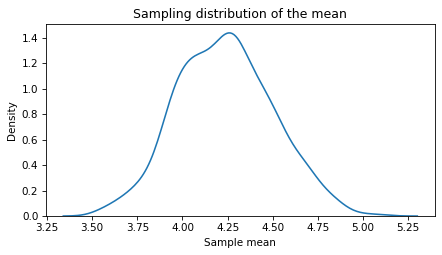

In [16]:
sns.kdeplot(sample)
decorate(xlabel='Sample mean',
         ylabel='Density',
         title='Sampling distribution of the mean')

This distribution shows how precise our estimate of the mean is.
If we run the experiment again, the mean could plausibly be as low as 3.5 or as high as 5.0.

There are two ways to summarize this distribution.
First, the standard deviation of the sampling distribution is the standard error.

In [17]:
se = np.std(sample)
se

0.26519081413201323

Second, the interval from the 5th to the 95th percentile is a 90% confidence interval.

In [18]:
ci90 = np.percentile(sample, [5, 95])
ci90

array([3.82, 4.69])

To report the estimated mean and its standard error, you could write 4.23 ± 0.27.
To report the estimated mean and its confidence interval, you could write 4.23 (CI90: 3.82, 4.69).

The standard error and confidence interval contain pretty much the same information, so I think it's better to report one or the other, not both.

## Hypothesis testing

Now let's get to the last part of the question, whether it's OK to run a t-test with count data.
In general, a t-test works well if the variance of the data is not too big and the sample size is not too small.
But it's not easy to say how big or how small.

So, rather than worrying about when a t-test is OK or not, I suggest using simulations.
To demonstrate, suppose we have count data from two groups.

In [19]:
np.random.seed(17)

In [20]:
n = 4
p = 0.5
data1 = nbinom.rvs(n, p, size=30)
m1 = np.mean(data1)
m1

4.333333333333333

In [21]:
n = 4
p = 0.55
data2 = nbinom.rvs(n, p, size=30)
m2 = np.mean(data2)
m2

3.433333333333333

In [22]:
diff = m1 - m2
diff

0.8999999999999999

It looks like there is a difference in the means, but we might wonder if it could be due to chance.
To answer that question, we can simulate a world where there is actually no difference between the groups.
One way to do that is a permutation test, where we combine the groups, shuffle, then split them again, and compute the difference in means.

In [23]:
def simulate_two_groups(data1, data2):
    n, m = len(data1), len(data2)
    data = np.append(data1, data2)
    np.random.shuffle(data)
    group1 = data[:n]
    group2 = data[n:]
    return group1.mean() - group2.mean()

Each time we call this function, it computes a difference in means under the null hypothesis that there is actually no difference between the groups.

In [24]:
simulate_two_groups(data1, data2)

-0.4333333333333331

And if we run it 1000 times, we get a sample from the distribution of differences under the null hypothesis.

In [25]:
sample = [simulate_two_groups(data1, data2) for i in range(1000)]

Here's what that distribution looks like:

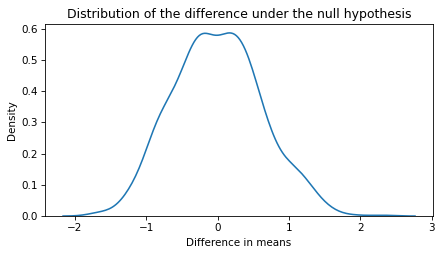

In [26]:
sns.kdeplot(sample)
decorate(xlabel='Difference in means',
         ylabel='Density',
         title='Distribution of the difference under the null hypothesis')

The mean of this distribution is close to 0, as we expect if the two groups are actually the same.

In [27]:
np.mean(sample)

-0.0017333333333333326

Now we can ask -- under the null hypothesis, what is the probability that we would see a difference as big as the one we saw (in either direction)?

In [28]:
p_value = np.mean(np.abs(sample) > diff)
p_value

0.136

The answer is about 14%, which means that if there is actually no difference between the groups, it would not be surprising to see a difference as big as `diff` by chance.
We can conclude that this dataset does not provide strong evidence that there is a substantial difference between the groups.

In the dataset I generated, the sample size in each group is 30.
In the dataset the OP asked about, the sample size in each group is only 3.
With such a small sample, the permutation test might not work well.
But with such a small sample, there is not much point in running a hypothesis test of any kind.
I think it would be better to consider the experiment exploratory and report descriptive statistics only.